## LSTM Layer and Time Series Prediction
Follows similar steps as the RNN notebook, but instead of simple RNN layer we will use a bi-directional LSTM layer. 

In [1]:
!pip3 install tensorflow==2.0.0.beta

     |████████████████████████████████| 87.9MB 118kB/s 
     |████████████████████████████████| 501kB 46.3MB/s 
     |████████████████████████████████| 3.1MB 48.3MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print ("check tensorflow version: ", tf.__version__) 

check tensorflow version:  2.0.0-beta0


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.6,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")  
baseline = 10
amplitude = 40
slope = 0.06
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

###### Check the Other notebook to understand what exactly the function does

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
train_dataset = windowed_dataset(x_train, window_size=20, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [11]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)), 
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
                                    tf.keras.layers.Dense(1), 
                                    tf.keras.layers.Lambda(lambda x: x*100.)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, None, 1)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         33792     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_3 (Lambda)            (None, 1)                 0         
Total params: 75,073
Trainable params: 75,073
Non-trainable params: 0
_________________________________________________________________


In [12]:
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10 ** (epoch / 20)))
optimizer = tf.keras.optimizers.RMSprop(lr=1e-8, rho=0.89)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=["mae"],)

history = model.fit(train_dataset, epochs=100, callbacks=[learning_rate])

Epoch 1/100
8/8 [==============================] - 5s 636ms/step - loss: 88.6864 - mae: 89.0340
Epoch 2/100
8/8 [==============================] - 1s 121ms/step - loss: 88.6631 - mae: 89.0276
Epoch 3/100
8/8 [==============================] - 1s 120ms/step - loss: 88.6572 - mae: 89.0217
Epoch 4/100
8/8 [==============================] - 1s 120ms/step - loss: 88.6511 - mae: 89.0156
Epoch 5/100
8/8 [==============================] - 1s 117ms/step - loss: 88.6448 - mae: 89.0093
Epoch 6/100
8/8 [==============================] - 1s 120ms/step - loss: 88.6380 - mae: 89.0025
Epoch 7/100
8/8 [==============================] - 1s 119ms/step - loss: 88.6303 - mae: 88.9948
Epoch 8/100
8/8 [==============================] - 1s 116ms/step - loss: 88.6214 - mae: 88.9859
Epoch 9/100
8/8 [==============================] - 1s 116ms/step - loss: 88.6113 - mae: 88.9759
Epoch 10/100
8/8 [==============================] - 1s 116ms/step - loss: 88.5999 - mae: 88.9645
Epoch 11/100
8/8 [=====================

In [25]:
print ("type of history.history['lr]: ", type(history.history['lr']))
print ("minimum value of loss: ", min(history.history['loss']))
min_indcs = [i for i, x in enumerate(history.history['loss']) if x==min(history.history['loss'])]
final_lr = history.history['lr'][min_indcs[0]]
print ("corresponding index: ", min_indcs)
print ("corresponding learning rate: ", history.history['lr'][min_indcs[0]])

type of history.history['lr]:  <class 'list'>
minimum value of loss:  6.657327646138716
corresponding index:  [82]
corresponding learning rate:  0.00012589255


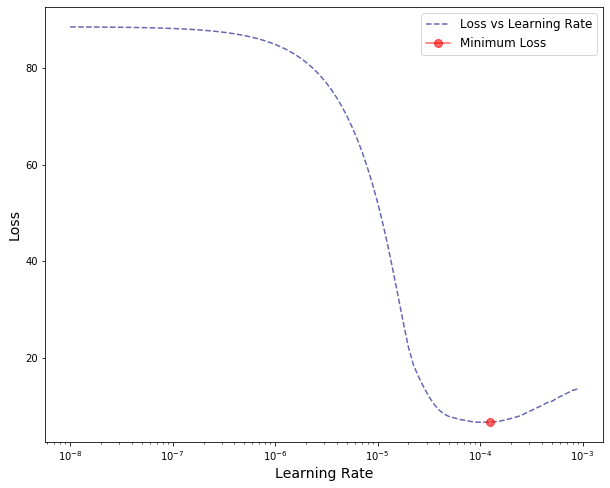

In [24]:
figure = plt.figure(figsize=(10, 8))
lr_rms = history.history['lr']
loss_rms = history.history['loss']
plt.semilogx(lr_rms, loss_rms, linestyle='--', color='navy', alpha=0.6, label='Loss vs Learning Rate')
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.plot(history.history['lr'][min_indcs[0]], min(history.history['loss']), marker='o', markersize=8, color='red', alpha=0.6, label='Minimum Loss')
plt.legend(numpoints=1, fontsize=12)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [27]:
tf.keras.backend.clear_session()
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=tf.keras.optimizers.RMSprop(lr=final_lr, rho=0.89), 
              metrics=["mae"])

history1 = model.fit(train_dataset,epochs=500,verbose=2)

Epoch 1/500
31/31 - 5s - loss: 12.6751 - mae: 13.1953
Epoch 2/500
31/31 - 1s - loss: 8.2250 - mae: 8.7024
Epoch 3/500
31/31 - 1s - loss: 7.2498 - mae: 7.7279
Epoch 4/500
31/31 - 1s - loss: 6.6042 - mae: 7.0728
Epoch 5/500
31/31 - 1s - loss: 6.1755 - mae: 6.6431
Epoch 6/500
31/31 - 1s - loss: 5.8867 - mae: 6.3586
Epoch 7/500
31/31 - 1s - loss: 5.6454 - mae: 6.1132
Epoch 8/500
31/31 - 1s - loss: 5.5036 - mae: 5.9757
Epoch 9/500
31/31 - 1s - loss: 5.4120 - mae: 5.8846
Epoch 10/500
31/31 - 1s - loss: 5.3122 - mae: 5.7831
Epoch 11/500
31/31 - 1s - loss: 5.2471 - mae: 5.7182
Epoch 12/500
31/31 - 1s - loss: 5.2070 - mae: 5.6792
Epoch 13/500
31/31 - 1s - loss: 5.1498 - mae: 5.6213
Epoch 14/500
31/31 - 1s - loss: 5.1026 - mae: 5.5747
Epoch 15/500
31/31 - 1s - loss: 5.0631 - mae: 5.5333
Epoch 16/500
31/31 - 1s - loss: 5.0272 - mae: 5.4957
Epoch 17/500
31/31 - 1s - loss: 4.9889 - mae: 5.4571
Epoch 18/500
31/31 - 1s - loss: 4.9511 - mae: 5.4187
Epoch 19/500
31/31 - 1s - loss: 4.9206 - mae: 5.3876


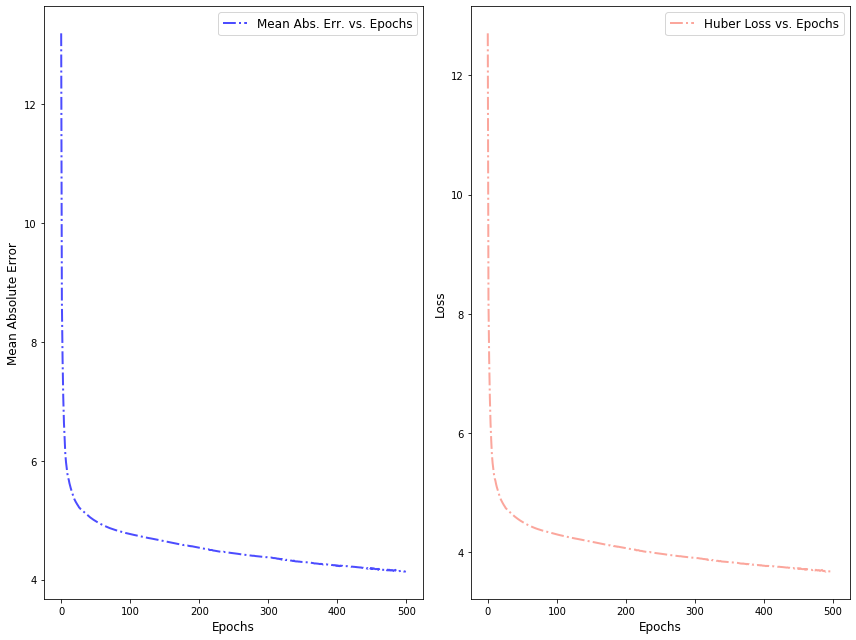

In [29]:
fig = plt.figure(figsize=(12, 9))

mae_final = history1.history['mae']
loss_final = history1.history['loss']
num_steps = range(len(mae_final))

plt.subplot(1, 2, 1)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Mean Absolute Error", fontsize=12)
plt.plot(num_steps, mae_final, linestyle='-.', linewidth=2, color='blue', alpha=0.7, label='Mean Abs. Err. vs. Epochs')
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(num_steps, loss_final, linestyle='-.', linewidth=2, color='salmon', alpha=0.7, label='Huber Loss vs. Epochs')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

##### Prediction Time 

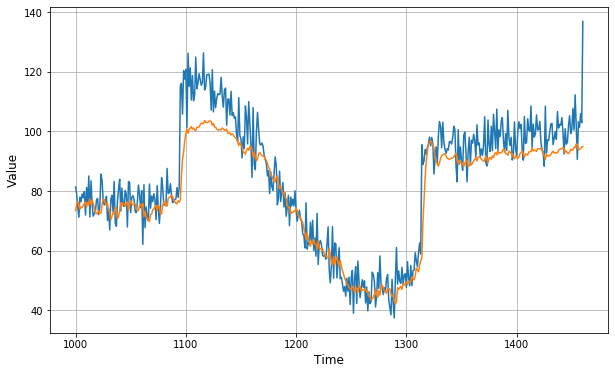

In [30]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [32]:
print ("final MAE: ", tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

final MAE:  6.291924
